# Roberts Code (LSTM based)

## Datasets
**Do not run**
For info only

### Pick a dataset

#### High Gamma Dataset
[Github Link to project](https://github.com/robintibor/high-gamma-dataset)

BELOW CODE DOESNT WORK NEED TO DO MANUALLY!!!!

In [ ]:
#!git clone https://gin.g-node.org/robintibor/high-gamma-dataset.git

In [ ]:
#!npx degit /robintibor/high-gamma-dataset -f

#### BCI2000
[data](https://physionet.org/content/eegmmidb/1.0.0/)

[paper: BCI2000: a general-purpose brain-computer interface (BCI) system](https://pubmed.ncbi.nlm.nih.gov/15188875/)

TOO BIG!

In [ ]:
#!wget -r -N -c -np https://physionet.org/files/eegmmidb/1.0.0/

#### BCIC IV 2a Dataset (Left, right, up, down based on left/right hand, foot and tongue)
[Description and citation](http://moabb.neurotechx.com/docs/generated/moabb.datasets.BNCI2014001.html?highlight=moabb%20paradigms)

[Article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3396284/)

Each run consits of :

![data format](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3396284/bin/fnins-06-00055-g016.jpg "Data format")

Since each run is 1001 samples at 250Hz (4 sec) long I assume we should remove the first second.

In [ ]:
#subject_id = 3
#dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids=[1])
#OR

dataset = BNCI2014001()

NameError: ignored

In [ ]:
dataset

## Feature Extraction

This is an appaling failure to make an LSTM autoencoder dont bother running it its not complete

**DO NOT RUN**

In [ ]:
class ScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(ScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x 1)

            The output must be a softmax weighting over the seq_len annotations.
        """

        # ------------
        # FILL THIS IN
        # ------------
        q = self.Q(queries)
        batch_size = queries.size()[0]
        if (len(queries.size()) < 3):
          q = torch.unsqueeze(q, 1)
        k = self.K(keys)
        v = self.V(values)
        print("key size: ", k.size())
        print("q size: ", q.size())

        unnormalized_attention = torch.bmm(q, torch.transpose(k, 2, 1))* self.scaling_factor
        attention_weights = self.softmax(unnormalized_attention)
        print("att weight: ", attention_weights.size())
        context = torch.squeeze(torch.bmm(torch.transpose(attention_weights, 2, 1) , v)) #NOT masked
        
        return context, attention_weights

In [ ]:
class Encoder (nn.Module):

  def __init__(self, input_sizes, hidden_sizes, layersperlayer, kernel):

    super(Encoder, self).__init__()

    self.hidden_sizes = hidden_sizes
    self.input_sizes = input_sizes[:-1]
    self.output_sizes = input_sizes[1:]

    print([(i,h) for i, h in zip(input_sizes, hidden_sizes)])
    self.LSTMS = nn.ModuleList([nn.LSTM(input_size=i, hidden_size=h, num_layers=layersperlayer, batch_first=True) for i, h in zip(input_sizes, hidden_sizes)])
    self.attention_network = nn.ModuleList([ScaledDotAttention(h) for h in hidden_sizes])
    #self.linear = nn.ModuleList([nn.Linear(i, o) for i, o in zip(input_sizes, self.output_sizes)])
    self.conv = nn.ModuleList([nn.Conv1d(i, o, kernel) for i, o in zip(input_sizes, self.output_sizes)])

  def forward(self, input):
    batch_size, channel, seq_len = input.size()
    print(input.size())
    input = torch.reshape(input, (batch_size, seq_len, channel))
    hidden = torch.zeros(batch_size, self.hidden_sizes[0])#self.init_hidden(batch_size)
    cell = torch.zeros(batch_size, self.hidden_sizes[0])#self.init_hidden(batch_size)

    for i in range(len(self.hidden_sizes)):
      print(input.size())
      annotations, hidden = self.LSTMS[i](input) #, (hidden, cell))
      print("annotations: ", annotations.size())
      contexts, attention_weights = self.attention_network[i](annotations, annotations, annotations)
      print("context: ", contexts.size())
      input = self.linear[i](contexts)

  

  def init_hidden(self, bs):
        """Creates a tensor of zeros to represent the initial hidden states
        of a batch of sequences.

        Arguments:
            bs: The batch size for the initial hidden state.

        Returns:
            hidden: An initial hidden state of all zeros. (batch_size x hidden_size)
        """
        return to_var(torch.zeros(bs, self.hidden_size), self.opts.cuda)

In [ ]:
class Decoder (nn.Module):

  def __init__(self, input_size, hidden_sizes, num_layers):

    super(Decoder, self).__init__()

    self.hidden_sizes = hidden_sizes
    self.start_size = hidden_sizes[::-1][:-1]
    self.end_size = hidden_sizes[::-1][1:]

    self.LSTMS = nn.ModuleList([nn.LSTM(input_size=s, hidden_size=e, 1) for s, e in zip(self.start_size, self.end_size)])
    self.attention_network = nn.Sequential(
                                nn.Linear(hidden_size*2, hidden_size),
                                nn.ReLU(),
                                nn.Linear(hidden_size, 1)
                             )
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input):

    for i in range(len(heddensizes)):

SyntaxError: ignored

In [ ]:
class AutoEncoder (nn.Module):

  def __init__(self, input_size, hidden_sizes, num_layers):

    super(AdditiveAttention, self).__init__()

    self.hidden_sizes = hidden_sizes
    self.start_size = hidden_sizes[:-1] + hidden_sizes[::-1][:-1]
    self.end_size = hidden_sizes[1:] + hidden_sizes[::-1][1:]

    self.LSTMS = nn.ModuleList([nn.LSTM(input_size=s, hidden_size=e, 1) for s, e in zip(self.start_size, self.end_size)])
    self.attention_network = nn.Sequential(
                                nn.Linear(hidden_size*2, hidden_size),
                                nn.ReLU(),
                                nn.Linear(hidden_size, 1)
                             )
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input):

    for i in range(len(heddensizes)):



## Imports

In [2]:
!pip install download
!python -c "from download import download; download('https://raw.githubusercontent.com/NeuroTechX/moabb/master/requirements.txt', 'requirements.txt', replace=True)"
!pip install -r requirements.txt
!rm requirements.txt
!pip install -U https://github.com/NeuroTechX/moabb/archive/master.zip


!pip install braindecode
#!wget -O feature_extraction.py https://raw.githubusercontent.com/skyli42/CSC413S2021-Team-22/ba764addb1107740d018e33679f40074a47bf698/feature_extraction.py 

#from feature_extraction import feature_extract
from braindecode.datasets.moabb import MOABBDataset
import mne
from braindecode.datautil.windowers import create_windows_from_events
from braindecode.datautil.preprocess import exponential_moving_standardize
from braindecode.datautil.preprocess import MNEPreproc, NumpyPreproc, preprocess

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/download/download.py", line 208, in _fetch_file
    u = urllib.request.urlopen(req, timeout=timeout)
  File "/usr/lib/python3.7/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/usr/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/usr/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/usr/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/usr/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/usr/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found

During handling of the above exception, another exception occurred:

Traceback (most recent call last

     |████████████████████████████████| 102kB 6.5MB/s 
     |████████████████████████████████| 133kB 15.6MB/s 
  Created wheel for braindecode: filename=Braindecode-0.5-cp37-none-any.whl size=53741 sha256=79691fdb37b272beca51fd4434d1e57ec79c22265113fba504076358c8217f57
  Stored in directory: /root/.cache/pip/wheels/2d/dc/b4/8db33baacda83683788e6f94a8a9dd5791bf3f65b17fd60c66
Successfully built braindecode


In [3]:
from feature_extraction import feature_extract

### EEG brain code

[Github project](https://github.com/braindecode/braindecode)

[https://braindecode.org/index.html](documentation)

In [4]:
!pip install braindecode
from braindecode.datasets.bbci import  BBCIDataset
from braindecode.datasets.moabb import MOABBDataset     #Braindecode stuff not sure if we will go this route 
import mne

### Other imports

In [5]:
import os
import pdb
import argparse
import pickle as pkl

from collections import defaultdict

#!pip install numpy --upgrade
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.autograd import Variable

from six.moves.urllib.request import urlretrieve
import tarfile
import pickle
import sys

from tqdm import tqdm

from scipy.signal import welch, spectrogram
from scipy.ndimage.interpolation import shift
from scipy.stats import kurtosis
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, cohen_kappa_score

## Utility Functions

In [6]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [7]:
def print_opts(opts):
    """Prints the values of all command-line arguments.
    """
    print('=' * 80)
    print('Opts'.center(80))
    print('-' * 80)
    for key in opts.__dict__:
        print('{:>30}: {:<30}'.format(key, opts.__dict__[key]).center(80))
    print('=' * 80)

In [8]:
def get_accuracy(model, data):
  wrongs = 0
  data_size = 0
  for X, y in data: #tqdm(data, "Computing Accuracy", leave=False):
    pred = torch.argmax(model(X),1)
    wrongs += torch.count_nonzero(pred - y)
    data_size += X.size()[0]
  wrongs = wrongs.item()
  return (data_size-wrongs)/data_size

In [57]:
def get_metrics(model, data):
  labels = []
  preds = []
  for X, y in data: #tqdm(data, "Computing Accuracy", leave=False):
    preds.append(torch.argmax(model(X),1).cpu().detach().numpy())
    labels.append(y.cpu().detach().numpy())

  labels = np.concatenate(labels)
  preds = np.concatenate(preds)

  recall = recall_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  kappa = cohen_kappa_score(labels, preds)
  return recall, precision, kappa

In [10]:
'''
def get_accuracy(model, data, device):
  preds = torch.empty(0).to(device)
  y_true= torch.empty(0).to(device)
  for X, y in data:
    pred = torch.argmax(model(reshape_X(X)),1)
    preds = torch.cat((preds, pred))
    y_true = torch.cat((y_true, y))
  return torch.sum((preds==y_true).long()).item()/len(preds)
'''

'\ndef get_accuracy(model, data, device):\n  preds = torch.empty(0).to(device)\n  y_true= torch.empty(0).to(device)\n  for X, y in data:\n    pred = torch.argmax(model(reshape_X(X)),1)\n    preds = torch.cat((preds, pred))\n    y_true = torch.cat((y_true, y))\n  return torch.sum((preds==y_true).long()).item()/len(preds)\n'

## Data Prep



#### Loader

In [11]:
code_dict = {'feet':0, 'left_hand':1, 'right_hand':2, 'tongue':3}

def create_Loaders(subjects, opts): #data, paradigm, batchSize, windowSize):
  #X, y, metadata = paradigm.get_data(dataset=data, subjects=[1])
  #y = np.array([code_dict[i] for i in list(y)])

  '''
  repeats = int(750/windowSize)
  X, y, metadata = paradigm.get_data(dataset=dataset)

  y = np.array([code_dict[i] for i in list(y)])
  #y = np.eye(4)[y] #appearently crossEntropyLoss takes indices not one-hot
  y = np.repeat(y, repeats, axis=0)

  X = np.reshape(X[..., 250:1000], (repeats*X.shape[0], X.shape[1], windowSize))  #From dataset documentation it seems that the first 1 sec (250 samples cause 250Hz ampling) is just displaying visual image not motor imagery
  '''

  #Z = overlap_window(X, windowSize, windowSize//2, 2) # returns: trial x channel x window x sample

  X_train, y_train, X_val, y_val, X_test, y_test = feature_extract(subjects, opts.window_size, opts.augmentation_factor, opts.augmentation_noise, opts.trunc_start, opts.trunc_end) # returns: trials x Channels x Feature x Window
  print(X_train.shape)
  print(y_train.shape)


  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2], X_train.shape[3]))
  X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1]*X_val.shape[2], X_val.shape[3]))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2], X_test.shape[3]))

  X_train = torch.tensor(X_train).float().to('cuda') # Remove first second since its only the cue
  y_train = torch.tensor(y_train).long().to('cuda')
  train = TensorDataset(X_train, y_train) # create your datset

  X_val = torch.tensor(X_val).float().to('cuda') # Remove first second since its only the cue
  y_val = torch.tensor(y_val).long().to('cuda')
  val = TensorDataset(X_val, y_val) # create your datset

  X_test = torch.tensor(X_test).float().to('cuda') # Remove first second since its only the cue
  y_test = torch.tensor(y_test).long().to('cuda')
  test = TensorDataset(X_test, y_test) # create your datset  

  train = DataLoader(train, batch_size=opts.batch_size)
  val = DataLoader(val, batch_size=opts.batch_size)
  test = DataLoader(test, batch_size=opts.batch_size)

  return train, val, test

#### Prep Data

In [12]:
def prep_data(subjects, opts):
  return create_Loaders(subjects, opts)#(dataset,paradigm, opts.batch_size, opts.window_size)

## Training funcs

### Compute Loss

In [13]:
def compute_loss(data, encoder, criterion, optimizer, opts):

    losses = []

    for X, y in data:
        outputs = encoder(X)
                    
        #print("out", outputs.size())
        #print("y", y.size())
        loss = criterion(outputs, y)
        #print("Batch loss: ", loss)
        losses.append(loss.item())
        
        ## training if an optimizer is provided
        if optimizer:
          # Zero gradients
          optimizer.zero_grad()
          # Compute gradients
          loss.backward()
          # Update the parameters of the encoder and decoder
          optimizer.step()
    #print(outputs)
    #print()

    return losses

### Training Loop

In [14]:
def training_loop(train, val, encoder, criterion, optimizer, opts):

    #loss_log = open(os.path.join(opts.checkpoint_path, 'loss_log.txt'), 'w')

    best_val_loss = 1e6
    train_losses = []
    val_losses = []
    
    mean_train_losses = []
    mean_val_losses = []

    early_stopping_counter = 0
    
    for epoch in range(opts.nepochs):

        optimizer.param_groups[0]['lr'] *= opts.lr_decay
        
        train_loss = compute_loss(train, encoder, criterion, optimizer, opts)
        val_loss = compute_loss(val, encoder, criterion, None, opts)

        mean_train_loss = np.mean(train_loss)
        mean_val_loss = np.mean(val_loss)

        if mean_val_loss < best_val_loss:
            #checkpoint(encoder, decoder, idx_dict, opts)
            best_val_loss = mean_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        if early_stopping_counter > opts.early_stopping_patience:
            print("Validation loss has not improved in {} epochs, stopping early".format(opts.early_stopping_patience))
            print("Obtained lowest validation loss of: {}".format(best_val_loss))
            return (mean_train_losses, mean_val_losses)

        #gen_string = translate_sentence(TEST_SENTENCE, encoder, decoder, idx_dict, opts)
        print("Epoch: {:3d} | Train loss: {:.3f} | Val loss: {:.3f}".format(epoch, mean_train_loss, mean_val_loss))

        #loss_log.write('{} {} {}\n'.format(epoch, train_loss, val_loss))
        #loss_log.flush()

        train_losses += train_loss
        val_losses += val_loss

        mean_train_losses.append(mean_train_loss)
        mean_val_losses.append(mean_val_loss)

        #save_loss_plot(mean_train_losses, mean_val_losses, opts)

    print("Obtained lowest validation loss of: {}".format(best_val_loss))
    return (mean_train_losses, mean_val_losses)

### Train Function

In [15]:
def train(opts, train, val, test):
    seq_length = 0
    for X, y in train:
      seq_length = X.size()[-1]


    encoder = Encoder(opts.input_size, opts.hidden_size, opts.lstm_layers, seq_len=seq_length) #22 for eeg channels MUST NOW TAKE INTO ACCOUNT FEATURES

    if opts.cuda:
        encoder.cuda()
        print("Moved models to GPU!")

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(list(encoder.parameters()), lr=opts.learning_rate, weight_decay=opts.l2_reg)  

    try:
        losses = training_loop(train, val, encoder, 
                               criterion, optimizer, opts)
    except KeyboardInterrupt:
        print('Exiting early from training.')
        return encoder, losses
      
    return encoder, losses

## Model

### Attention

In [16]:
class ScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(ScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x 1)

            The output must be a softmax weighting over the seq_len annotations.
        """

        q = self.Q(queries)
        batch_size = queries.size()[0]
        if (len(queries.size()) < 3):
          q = torch.unsqueeze(q, 1)
        k = self.K(keys)
        v = self.V(values)
        #print("key size: ", k.size())
        #print("q size: ", q.size())

        unnormalized_attention = torch.bmm(q, torch.transpose(k, 1, 2))* self.scaling_factor
        attention_weights = self.softmax(unnormalized_attention)
        #print("att weight: ", attention_weights.size())
        #context = torch.squeeze(torch.bmm(torch.transpose(attention_weights, 1, 2) , v)) #NOT masked
        context = torch.bmm(torch.transpose(attention_weights, 1, 2) , v) #NOT masked
        
        return context, attention_weights

In [17]:
class AdditiveAttention(torch.nn.Module):	 	 
    def __init__(self, encoder_dim=100, decoder_dim=50):	 	 
        super().__init__()	 	 

        self.encoder_dim = encoder_dim	 	 
        self.decoder_dim = decoder_dim	 	 
        self.v = torch.nn.Parameter(torch.rand(self.decoder_dim))	 	 
        self.W_1 = torch.nn.Linear(self.decoder_dim, self.decoder_dim)	 	 
        self.W_2 = torch.nn.Linear(self.encoder_dim, self.decoder_dim)	 	 

    def forward(self, 	 	 
      query, # [decoder_dim]	 	 
      values # [seq_length, encoder_dim]	 	 
    ):	 	 
        weights = self._get_weights(query, values) # [seq_length]	 	 
        weights = torch.nn.functional.softmax(weights, dim=0)	 	 
        return weights @ values # [encoder_dim]	 	 

    def _get_weights(self, 	 	 
      query, # [decoder_dim]	 	 
      values # [seq_length, encoder_dim]	 	 
    ):	 	 
        query = query.repeat(values.size(0), 1) # [seq_length, decoder_dim]	 	 
        weights = self.W_1(query) + self.W_2(values) # [seq_length, decoder_dim]	 	 
        return torch.tanh(weights) @ self.v # [seq_length]

### Encoder

In [18]:
class Encoder(nn.Module):

  def __init__(self, input_size, hidden_size, num_layers, seq_len):

    super(Encoder, self).__init__()

    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.attention_network = ScaledDotAttention(hidden_size)
    #self.attention_network = AdditiveAttention(hidden_size, hidden_size)
    #self.attention_network = nn.MultiheadAttention(hidden_size, 1)
    #self.linear = nn.Sequential(nn.Dropout(0.5), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Dropout(0.5), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 4)) # 4 is num of classes change to use num_layers
    self.linear = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 4)) # 4 is num of classes change to use num_layers
    self.bn_in = nn.BatchNorm1d(input_size)
    self.bn = nn.BatchNorm1d(self.hidden_size)
    self.softmax = nn.LogSoftmax(dim=1)
    self.do = nn.Dropout(0.1)
    
    self.positional_encodings = self.create_positional_encodings(max_seq_len=seq_len)

  def forward(self, input):
    batch_size, channel, seq_len = input.size()

    #normalized_input = self.bn_in(input)
    normalized_input = input
    annotations, hidden = self.lstm(torch.reshape(normalized_input, (batch_size, seq_len, channel)))
    
    annotations = torch.transpose(self.bn(torch.transpose(annotations, 1, 2)), 1, 2)
    annotations = annotations + torch.reshape(input, (batch_size, seq_len, channel))  #the residual seems to work better then the position
    annotations = annotations  + self.positional_encodings   #the residual seems to work better then the position
    
    #annotations = torch.reshape(annotations, (seq_len, batch_size, channel))
    contexts, attention_weights = self.attention_network(annotations, annotations, annotations)
    contexts = torch.transpose(self.bn(torch.transpose(contexts, 1, 2)), 1, 2)
    #contexts = torch.reshape(contexts, (batch_size, seq_len, channel))
    
    output = self.linear(torch.mean(contexts, dim=1))
    #output = self.linear(contexts[:,-1,:])
    
    return  self.softmax(output)


  def create_positional_encodings(self, max_seq_len=28):
    """Creates positional encodings for the inputs.
    Arguments:
        max_seq_len: a number larger than the maximum string length we expect to encounter during training
    Returns:
        pos_encodings: (max_seq_len, hidden_dim) Positional encodings for a sequence with length max_seq_len. 
    """
    pos_indices = torch.arange(max_seq_len)[..., None]
    dim_indices = torch.arange(self.hidden_size//2)[None, ...]
    exponents = (2*dim_indices).float()/(self.hidden_size)
    trig_args = pos_indices / (10000**exponents)
    sin_terms = torch.sin(trig_args)
    cos_terms = torch.cos(trig_args)
    pos_encodings = torch.zeros((max_seq_len, self.hidden_size))
    pos_encodings[:, 0::2] = sin_terms
    pos_encodings[:, 1::2] = cos_terms
    pos_encodings = pos_encodings.cuda()
    #if self.opts.cuda:
    #    pos_encodings = pos_encodings.cuda()
    return pos_encodings


## Train

In [ ]:
options = AttrDict()
dict_op = {
              'batch_size':128,
              'augmentation_factor': 30,
              'augmentation_noise': 0.5,
              'window_size':75,
              'cuda':True,
}
options.update(dict_op)

train_data, val_data, test_data = prep_data([1], options)

48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 

In [ ]:
dict_op = {
              'nepochs':100,
              'learning_rate':0.00001,
              'lr_decay':0.99,
              'l2_reg': 0.001,
              'hidden_size':12*22, #must be same as input size to use residual connection
              'input_size': 12*22,
              'lstm_layers': 10,
              'cuda':True,
              'early_stopping_patience': 300
}
options.update(dict_op)
print(options)
model, loss = train(options, train_data, val_data, test_data)
print("Train Accuracy: ", get_accuracy(model, train_data))
print("Val Accuracy: ", get_accuracy(model, val_data))

{'batch_size': 128, 'augmentation_factor': 30, 'augmentation_noise': 0.5, 'window_size': 75, 'cuda': True, 'nepochs': 100, 'learning_rate': 1e-05, 'lr_decay': 0.99, 'l2_reg': 0.001, 'hidden_size': 264, 'input_size': 264, 'lstm_layers': 10, 'early_stopping_patience': 300}
Moved models to GPU!
Epoch:   0 | Train loss: 1.388 | Val loss: 1.393
Epoch:   1 | Train loss: 1.386 | Val loss: 1.385
Epoch:   2 | Train loss: 1.384 | Val loss: 1.389
Epoch:   3 | Train loss: 1.384 | Val loss: 1.393
Epoch:   4 | Train loss: 1.384 | Val loss: 1.396
Epoch:   5 | Train loss: 1.382 | Val loss: 1.394
Epoch:   6 | Train loss: 1.381 | Val loss: 1.393
Epoch:   7 | Train loss: 1.380 | Val loss: 1.395
Epoch:   8 | Train loss: 1.378 | Val loss: 1.392
Epoch:   9 | Train loss: 1.379 | Val loss: 1.392
Epoch:  10 | Train loss: 1.378 | Val loss: 1.388
Epoch:  11 | Train loss: 1.377 | Val loss: 1.389
Epoch:  12 | Train loss: 1.377 | Val loss: 1.392
Epoch:  13 | Train loss: 1.375 | Val loss: 1.389
Epoch:  14 | Train lo

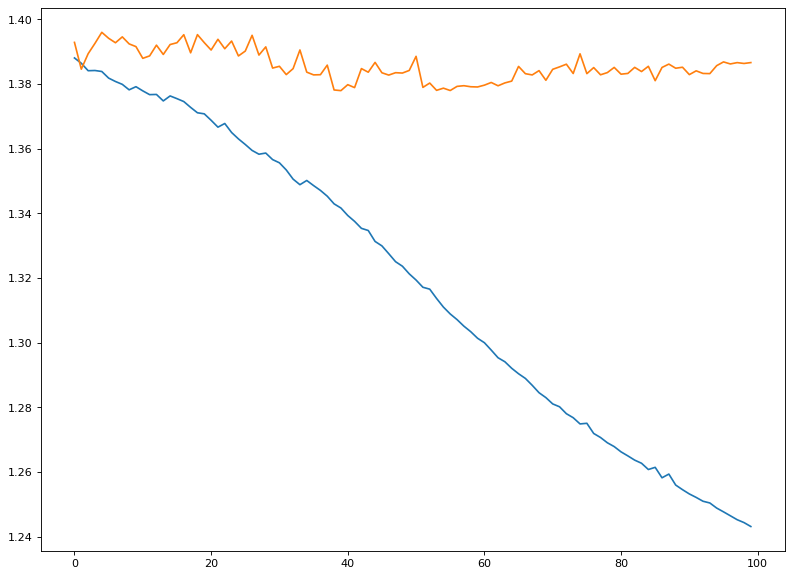

In [ ]:
plt.figure(figsize=(12, 9), dpi=80)
train_loss, val_loss = loss
plt.plot(train_loss)
plt.plot(val_loss)

In [ ]:
print("Train Accuracy: ", get_accuracy(model, train_data))
print("Val Accuracy: ", get_accuracy(model, val_data))

Train Accuracy:  0.5560281065088757
Val Accuracy:  0.703125


In [ ]:
print("test Accuracy: ", get_accuracy(model, test_data))

test Accuracy:  0.828125


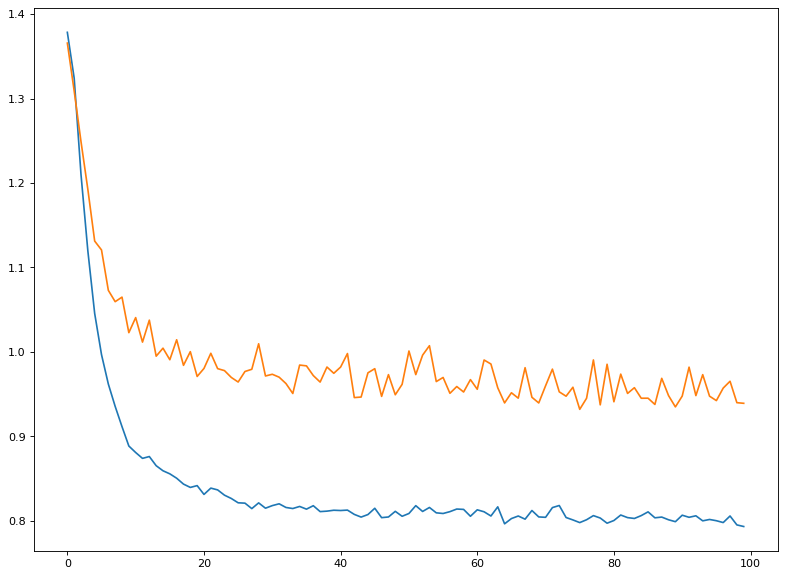

In [ ]:
plt.figure(figsize=(12, 9), dpi=80)
train_loss, val_loss = loss
plt.plot(train_loss)
plt.plot(val_loss)

In [ ]:
print("Train Accuracy: ", get_accuracy(model, train_data))
print("Val Accuracy: ", get_accuracy(model, val_data))

Train Accuracy:  0.9464699074074074
Val Accuracy:  0.8016493055555556


In [ ]:
print("test Accuracy: ", get_accuracy(model, test_data))

test Accuracy:  0.7964409722222222


In [ ]:
for i, j in train_data:
  print(i.shape)
  break

## Do all subjects individually

In [58]:
def train_subjects(subjects, batch_size, aug_factor):  
  options = AttrDict()
  dict_op = {
                'batch_size': batch_size,
                'augmentation_factor': aug_factor,
                'augmentation_noise': 2,
                'window_size':75,
                'trunc_start': 5,
                'trunc_end': 20,
                'cuda':True,
  }
  options.update(dict_op)

  train_data, val_data, test_data = prep_data(subjects, options)
  
  dict_op = {
                'nepochs':300,
                'learning_rate':0.000005,
                'lr_decay':0.999,
                'l2_reg': 0.0001,
                'hidden_size':12*22, #must be same as input size to use residual connection
                'input_size': 12*22,
                'lstm_layers': 5,
                'cuda':True,
                'early_stopping_patience': 300
  }
  options.update(dict_op)
  print(options)
  model, loss = train(options, train_data, val_data, test_data)
  print("Train Accuracy: ", get_accuracy(model, train_data))
  print("Val Accuracy: ", get_accuracy(model, val_data))

  metrics = get_metrics(model, test_data)

  return get_accuracy(model, train_data), get_accuracy(model, val_data), get_accuracy(model, test_data), loss, metrics

Streaming output truncated to the last 5000 lines.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB

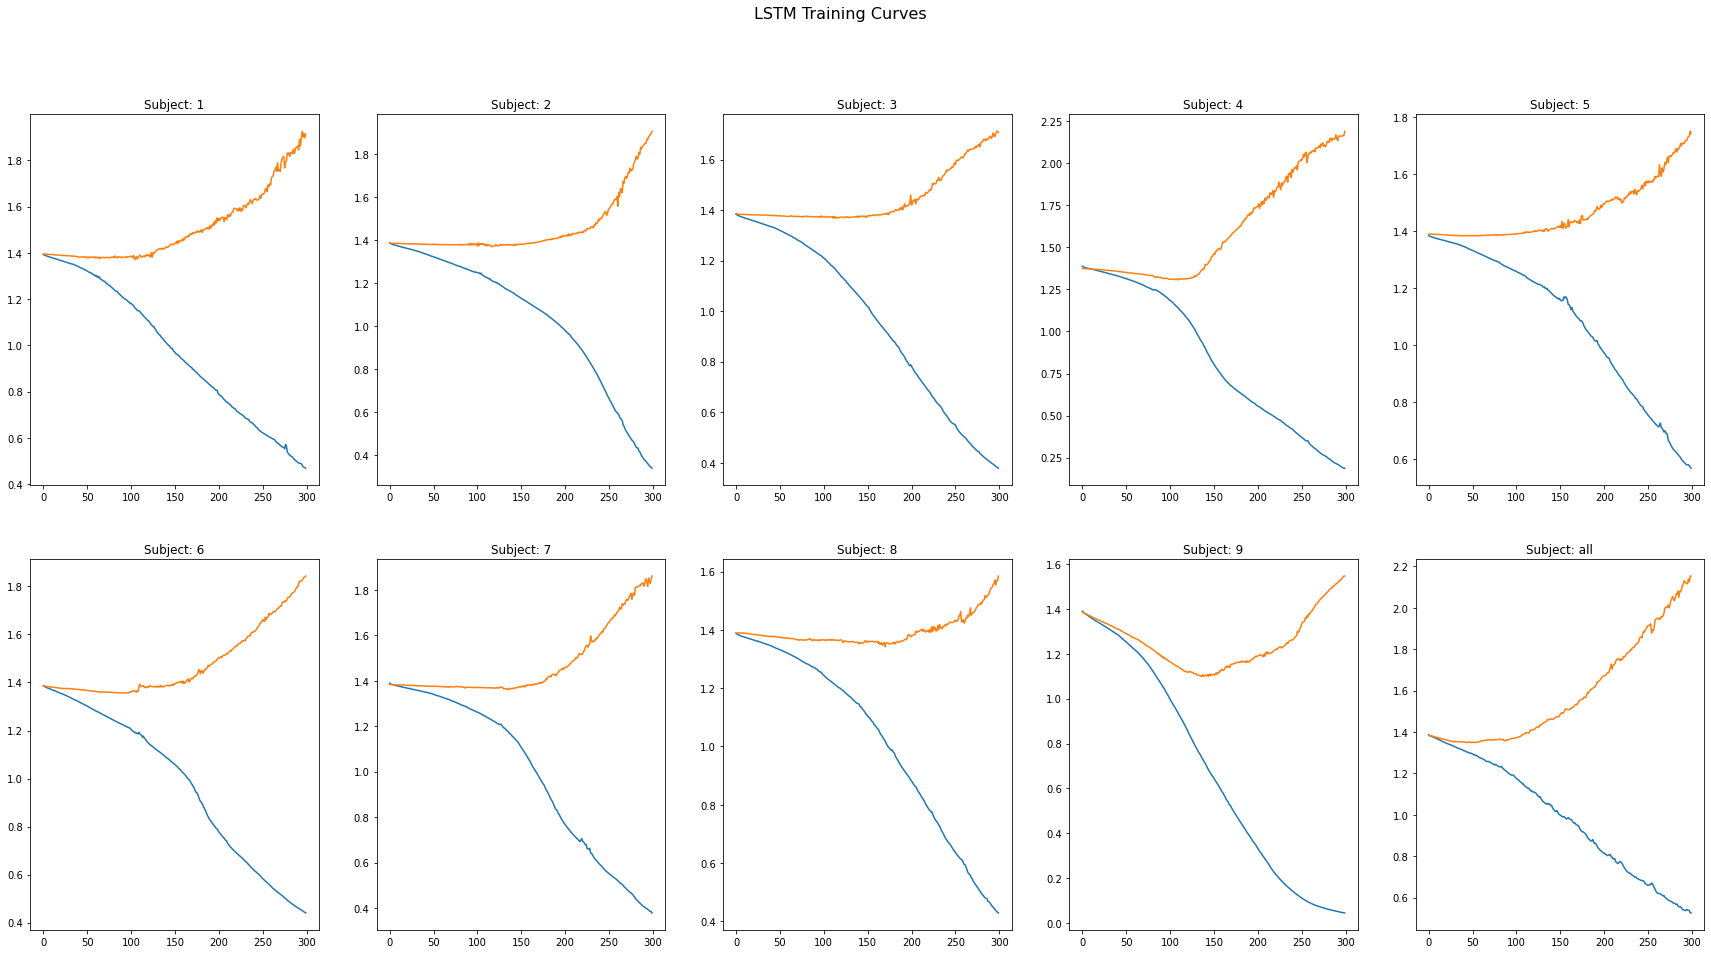

In [59]:
fig, axs = plt.subplots(2, 5)

fig.set_figheight(15)
fig.set_figwidth(30)

train_accs = []
val_accs = [] 
test_accs = []
kappas = []
recalls = []
precisions = []



for s in range(1, 10):
  train_acc, val_acc, test_acc, losses, metrics =  train_subjects([s], 32, 0)

  train_accs.append(train_acc)
  val_accs.append(val_acc)
  test_accs.append(test_acc)

  r, p, k = metrics
  kappas.append(k)
  recalls.append(r)
  precisions.append(p)

  train_loss, val_loss = losses
  axs[(s-1)//5, (s-1)%5].plot(train_loss, label="Training Loss")
  axs[(s-1)//5, (s-1)%5].plot(val_loss, label="Validation Loss")
  axs[(s-1)//5, (s-1)%5].set_title('Subject: %d' %s)



train_acc, val_acc, test_acc, losses, metrics =  train_subjects([1, 2, 3, 4, 5, 6, 7, 8, 9], 64, 0)
train_accs.append(train_acc)
val_accs.append(val_acc)
test_accs.append(test_acc)
train_loss, val_loss = losses
r, p, k = metrics
kappas.append(k)
recalls.append(r)
precisions.append(p)
axs[1, 4].plot(train_loss, label="Training Loss")
axs[1, 4].plot(val_loss, label="Validation Loss")
axs[1, 4].set_title('Subject: all')

fig.suptitle('LSTM Training Curves', fontsize=16)


print("train acc: ", train_accs)
print("val acc: ", val_accs)
print("test acc: ", test_accs)
print("recall: ", recalls)
print("precision: ", precisions)
print("kappa: ", kappas)

plt.show()

In [63]:
print(np.round(precisions, 4))
print(np.round(recalls, 4))

[0.3015 0.2255 0.2981 0.3458 0.3728 0.3078 0.3536 0.2116 0.5881 0.3276]
[0.3253 0.223  0.3131 0.35   0.3792 0.2921 0.3216 0.236  0.5927 0.3306]
